# Statistical Arbitrage
Bond Pairs Trade Ideas

The idea behind this notebook is to begin looking at pairs trading for the 10Y vs 5Y US Treasury Bonds. We start very simple to explore and create a trade idea pipeline, which we will expand upon, make increasingly complex and creative.

Firstly, we created methods for the following:-

1. Download Data from Yahoo Finance

2. Test for Stationarity  
   We use the Augmented Dickey Fuller test to check our data mean reverts

3. Compute Spread and Feature Data  
   We compute spread data, mean, std and bollinger bands here
   
4. Plot Bond Yields

5. Plot Bond Spread for a given Bond Pair

6. Plot Bond Spread Returns 
   To check for stationarity of bond spread returns
   
Secondly, we apply these methods to explore the viability of the trading idea

**TODO:**  
Thirdly, we implement our entry and exit points

**TODO:**  
Forthly, we create a back testing tear sheet using quantstats (very quick to do- one line of code)

**TODO:**  
Fifthly, add additional trading features, increase complexity and creativity. Generally a handful of features will be required to have any chance of being successful.

Once we have completed these steps we will have a basic bond pairs trading pipepline for backtesting, which we can configure and use to test other pairs and trading ideas.

In [6]:
# Import Packages
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Allow Multiple Outputs in Cells
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Disable Warnings
import warnings
warnings.filterwarnings('ignore')

## Define Data Labels
We define labels here so that if we need to correct a label we can do it one place, rather than everywhere!

In [7]:
# Define Column Names and Labels
# We do this here so that if we need to correct a label we can do it one place, rather than everywhere!

# Chart Labels
DATE = 'date'
PRICE = 'price'
YIELD = 'yield'

# Yahoo Finance Labels
CLOSE = 'Adj Close'

# Pandas DataFrame Labels
SPREAD = 'spread'
MEAN = 'mean'
STD = 'std'
SPREAD_RETURNS = 'spread_returns'
SPREAD_VS_MEAN = 'spread_vs_mean'
UPPER1 = 'upper1'
UPPER2 = 'upper2'
LOWER1 = 'lower1'
LOWER2 = 'lower2'

## Function Implementation

In [8]:
# Method to download data from yahoo finance
def download_data(tickers, start_date, end_date):
    prices = yf.download(tickers, start=start_date, end=end_date)[CLOSE]
    return prices

# Method to test for stationarity using the Augmented Dickey-Fuller Test
def test_stationarity(series_data):
    # Perform Dickey-Fuller test
    result = adfuller(series_data)
    p_value = result[1]

    # Test if p-value < 0.05
    is_stationary = p_value < 0.05
    message = 'Stationary' if is_stationary else 'Not Stationary'
    
    print(f'Series is {message} (p-value: {p_value*100:.2f}%)')

# Compute the Spread Data and Add to DataFrame
# window controls the mean and std period in days
def append_spread_data(price_data, window):
    
    # Compute the Spread as yields[0] - yields[1] i.e. longer bond tenor first
    price_data[SPREAD] = price_data.iloc[:, 0] - price_data.iloc[:, 1]

    # Calculate the rolling mean and standard deviation
    price_data[MEAN] = price_data[SPREAD].rolling(window=window).mean()
    price_data[STD] = price_data[SPREAD].rolling(window=window).std()
    
    # compute spread returns
    price_data[SPREAD_RETURNS] = price_data[SPREAD].pct_change()
    
    # Some spreads will be zero, when dividing by zero for returns this will give 'infinity' (inf) as the result
    # Here we replace +/- inf with Not a Number (nan), which we manager in other routines using dropna()
    price_data[SPREAD_RETURNS] = price_data[SPREAD_RETURNS].replace([np.inf, -np.inf], np.nan)
        
    price_data[SPREAD_VS_MEAN] = price_data[SPREAD_RETURNS] - price_data[MEAN]

# Compute Feature Data and Add to DataFrame
# window controls the mean and std period in days
# num_std is used to set the bollinger bands i.e. as a mulitple of number of standard deviations (num_std)
def append_feature_data(price_data, window, num_std):

    # Compute Bollinger Bands as a multiple of number of standard deviations (num_std)
    price_data[UPPER1] = price_data[MEAN] + (1 * num_std * price_data[STD])
    price_data[UPPER2] = price_data[MEAN] + (2 * num_std * price_data[STD])
    price_data[LOWER1] = price_data[MEAN] - (1 * num_std * price_data[STD])
    price_data[LOWER2] = price_data[MEAN] - (2 * num_std * price_data[STD])
    
# Method to plot yield data
def plot_yields(yields):
    plt.figure(figsize=(10, 6))
    for ticker in yields.columns:
        plt.plot(yields.index, yields[ticker], label=ticker)

    plt.title(YIELD)
    plt.xlabel(DATE)
    plt.ylabel(YIELD)
    plt.legend()
    plt.show()

# Method to plot the spread, mean and bollinger bands
def plot_spread(spread_data):
    
    plt.figure(figsize=(10, 4))
    plt.plot(spread_data.index, spread_data[SPREAD], label=SPREAD, color='red')
    plt.plot(spread_data.index, spread_data[MEAN], label=MEAN, color='black', linestyle='--')
    
    plt.plot(spread_data.index, spread_data[UPPER1], label=UPPER1, color='green')
    plt.plot(spread_data.index, spread_data[UPPER2], label=UPPER2, color='blue')
    
    plt.plot(spread_data.index, spread_data[LOWER1], label=LOWER1, color='green')
    plt.plot(spread_data.index, spread_data[LOWER2], label=LOWER2, color='blue')
    
    plt.title(SPREAD)
    plt.xlabel(DATE)
    plt.ylabel(SPREAD)
    
    plt.legend()
    plt.show()
    
# Method to plot the spread returns
def plot_spread_returns(spread_data):
    
    plt.figure(figsize=(10, 4))
    plt.plot(spread_data.index, spread_data[SPREAD_RETURNS], label=SPREAD_RETURNS, color='red')
    
    plt.title(SPREAD_RETURNS)
    plt.xlabel(DATE)
    plt.ylabel(SPREAD_RETURNS)
    
    plt.legend()
    plt.show()
    
# Method to plot the spread returns
def plot_spread_vs_mean(spread_data):
    
    plt.figure(figsize=(10, 4))
    plt.plot(spread_data.index, spread_data[SPREAD_VS_MEAN], label=SPREAD_VS_MEAN, color='red')
    
    plt.title(SPREAD_VS_MEAN)
    plt.xlabel(DATE)
    plt.ylabel(SPREAD_VS_MEAN)
    
    plt.legend()
    plt.show()

## Perform Bond Yield and Spread Analysis
Here we perform preliminary bond spread analysis

[*********************100%***********************]  2 of 2 completed


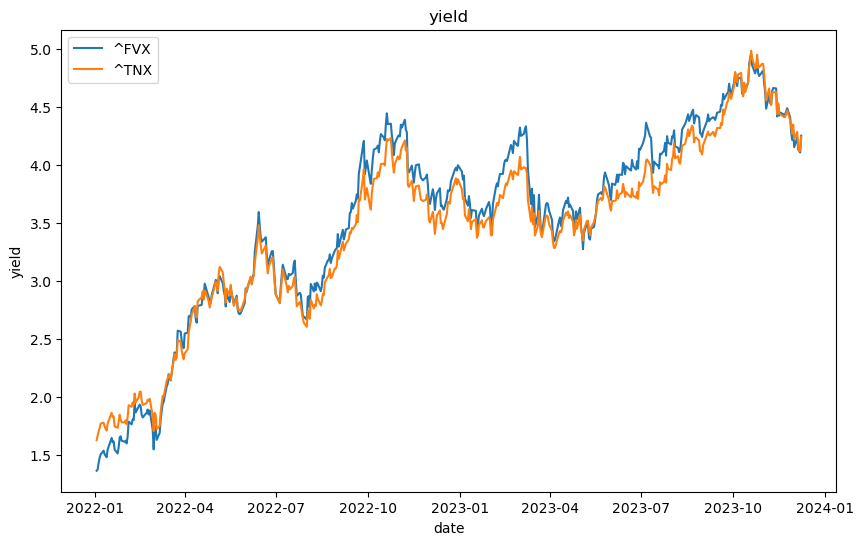

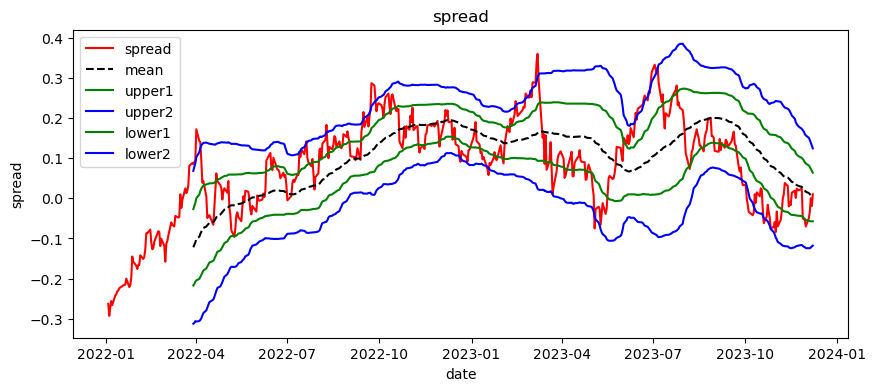

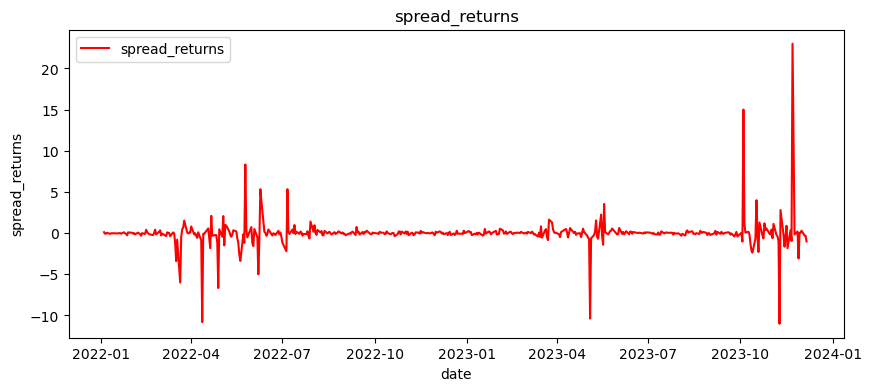


Testing if Spread is Stationary
Series is Stationary (p-value: 1.63%)

Testing if Spread Returns are Stationary
Series is Stationary (p-value: 0.00%)


In [9]:
# Define bond tickers
# ^IRX is the 13 Week US Treasury Bill
# ^FVX is the 5-Year US Treasury
# ^TNX is the 10-Year US Treasury
# ^TYX is the 30-Year US Treasury

# Parameters
bond_tickers = ['^TNX', '^FVX'] # 10 v 5
start_date = '2022-01-01'
end_date = '2023-12-10'
sma_window = 60
num_std = 1.0

# Get bond data
bond_data = download_data(bond_tickers, start_date, end_date)

# Plot bond yields
plot_yields(bond_data)

# Compute Spread Data
append_spread_data(bond_data, sma_window)
append_feature_data(bond_data, sma_window, num_std)

# Plot spread
plot_spread(bond_data)

# Plot spread Returns
plot_spread_returns(bond_data)

# Plot spread Returns
#plot_spread_vs_mean(bond_prices)

# Test Spread is Stationary
print(f'\nTesting if Spread is Stationary')
test_spread = bond_data[SPREAD]
test_stationarity(test_spread.dropna())

# Test Spread Returns are Stationary
print(f'\nTesting if Spread Returns are Stationary')
test_spread_returns = bond_data[SPREAD_RETURNS]
test_stationarity(test_spread_returns.dropna())

In [5]:
# Display Bond Data
bond_data.tail()

,^FVX,^TNX,spread,mean,std,spread_returns,spread_vs_mean,upper1,upper2,lower1,lower2
Date,,,,,,,,,,,
2023-12-04,4.238,4.288,-0.050,0.013167,0.068868,-0.285708,-0.298875,0.082034,0.150902,-0.055701,-0.124569
2023-12-05,4.137,4.171,-0.034,0.010500,0.067509,-0.320004,-0.330504,0.078009,0.145518,-0.057009,-0.124518
2023-12-06,4.121,4.121,0.000,0.008067,0.065131,-1.000000,-1.008067,0.073198,0.138329,-0.057065,-0.122196
2023-12-07,4.110,4.129,-0.019,0.005383,0.062795,NaN,NaN,0.068178,0.130972,-0.057411,-0.120206
2023-12-08,4.255,4.245,0.010,0.003367,0.060596,-1.526326,-1.529693,0.063963,0.124560,-0.057230,-0.117826
